In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [3]:
# 파생 변수 생성: "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [4]:
# 3. 범주형 데이터에 따른 부채확률 따로 구해 참고후 가중치 부여.
loan_period_map = {"단기 상환": 0, "장기 상환": 1}
loan_purpose_map = {
    "교통비": 0, "여행 자금": 1, "교육비": 2, "이사 비용": 3,
    "결혼 자금": 4, "사업 대출": 5, "투자금": 6, "자동차 구매": 7,
    "기타": 8, "부채 통합": 9, "휴가 비용": 10, "주택 개보수": 11
}
job_tenure_map = {
    "5년": 0, "4년": 1, "2년": 2, "6년": 3, "9년": 4,
    "3년": 5, "8년": 6, "10년 이상": 7, "7년": 8, "1년 미만": 9
}
housing_type_map = {"주택임대(월세 포함)": 0, "자가": 1, "주택담보대출(가구 중)": 2, "월세": 3}

col_loan_period = "대출 상환 기간"
col_loan_purpose = "대출 목적"
col_job_tenure = "현재 직장 근속 연수"
col_housing_type = "주거 형태"

for df in [X, test_df]:
    df[col_loan_period] = df[col_loan_period].map(loan_period_map)
    df[col_loan_purpose] = df[col_loan_purpose].map(loan_purpose_map)
    df[col_job_tenure] = df[col_job_tenure].map(job_tenure_map)
    df[col_housing_type] = df[col_housing_type].map(housing_type_map)

In [5]:
# 함수 정의: Winsorizing & IQR capping
# 원저화: 극한값의 영향을 줄여줌.
# 이 코드에선 상위,하위 1%를 임계값으로 설정.
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower_val = s.quantile(lower_quantile)
    upper_val = s.quantile(upper_quantile)
    return s.clip(lower_val, upper_val)

# 1사분위수와 3사분위수 사이에서 1.5배를 넘는 값 잘라냄.
def iqr_capping(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [7]:
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for df in [X, test_df]:
    # Winsorizing & 로그 변환
    for col in log_columns:
        df[col] = winsorize_series(df[col], 0.01, 0.99)
        df[col] = np.log1p(df[col])

In [6]:
for df in [X, test_df]:
    iqr_capping(df, "연간 소득", factor=1.5)

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

k_list = [5, 10, 15, 20, 25, 30]
k_auc_scores = {}

for k in k_list:
    imputer = KNNImputer(n_neighbors=k)
    X_imputed = imputer.fit_transform(X)
    model = LogisticRegression(random_state=42,max_iter=1000)
    scores = cross_val_score(model, X_imputed, y, cv=5, scoring='roc_auc')
    mean_auc = scores.mean()
    k_auc_scores[k] = mean_auc
    print(f"[K={k}] AUC : {mean_auc:.4f}")

[K=5] AUC : 0.6884
[K=10] AUC : 0.6888
[K=15] AUC : 0.6883
[K=20] AUC : 0.6869
[K=25] AUC : 0.6867
[K=30] AUC : 0.6864


In [8]:
knn_imputer = KNNImputer(n_neighbors=10)
X_imputed = knn_imputer.fit_transform(X)
test_imputed = knn_imputer.transform(test_df)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 학습
clf = LogisticRegressionCV(
    Cs=10,                  # 실험할 C값 10개 (자동 로그스케일 분포)
    cv=5,                   # 5-fold 교차검증
    penalty='l2',           # 정규화 종류 (l1, l2, elasticnet)
    solver='lbfgs',         # 최적화 알고리즘 (데이터에 따라 'liblinear', 'saga' 등 사용)
    scoring='roc_auc',      # 평가 지표
    max_iter=1000,
    random_state=42
)
clf.fit(X_train, y_train)

# 성능 확인
print("Best C values:", clf.C_)           # 교차검증으로 선택된 최적의 C
print("Train Score:", clf.score(X_train, y_train))
print("Test Score:", clf.score(X_test, y_test))

Best C values: [0.00599484]
Train Score: 0.70647490730481
Test Score: 0.6911832596267932


In [11]:
# 테스트 데이터 예측 & 저장
test_preds = clf.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({"UID": test_uid["UID"], "채무 불이행 확률": test_preds})
submission.to_csv("submission.csv", index=False)
print("✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.")

✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.


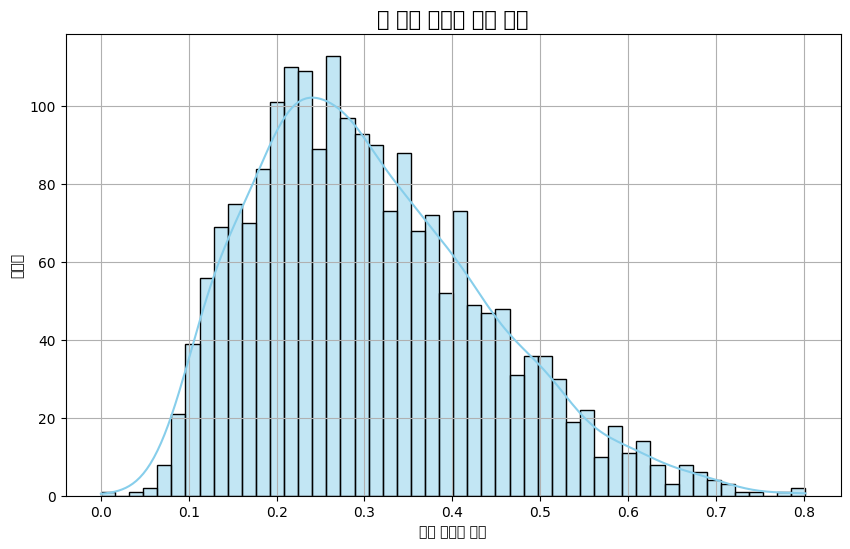

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 불러오기
df = pd.read_csv("submission.csv")

# 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df["채무 불이행 확률"], bins=50, kde=True, color="skyblue")
plt.title("🔍 채무 불이행 확률 분포", fontsize=15)
plt.xlabel("채무 불이행 확률")
plt.ylabel("빈도수")
plt.grid(True)
plt.show()

Train Score: 0.6965
Test Score : 0.6885


In [26]:
# 테스트 데이터 예측 & 저장
test_preds = sgd_model.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({"UID": test_uid["UID"], "채무 불이행 확률": test_preds})
submission.to_csv("submission.csv", index=False)
print("✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.")

✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.


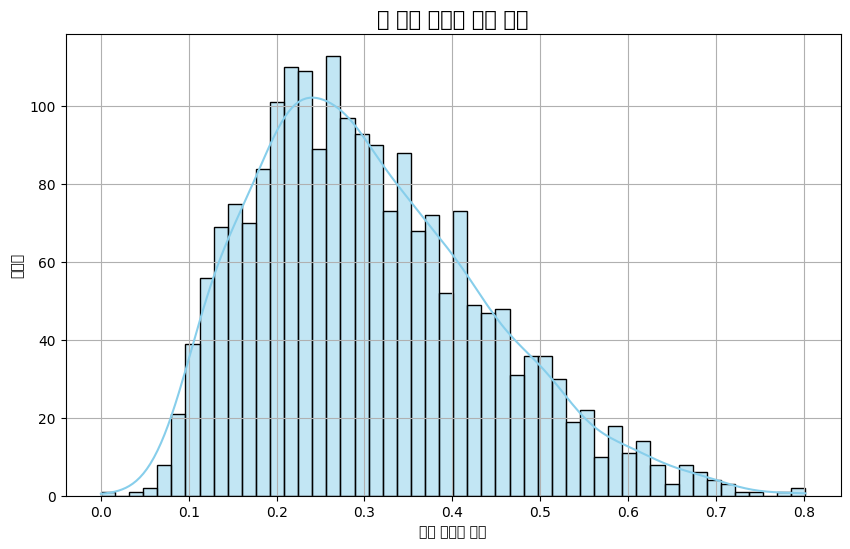

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일 불러오기
df = pd.read_csv("submission.csv")

# 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df["채무 불이행 확률"], bins=50, kde=True, color="skyblue")
plt.title("🔍 채무 불이행 확률 분포", fontsize=15)
plt.xlabel("채무 불이행 확률")
plt.ylabel("빈도수")
plt.grid(True)
plt.show()